## PyTorch Mechanics

This introduces some basic mechanics of pytorch (requires_grad, Xavier initialization, nn.Sequential, application to XOR, nn.module, custom layers), from chapter 13 of Raschka et al. The projects in this chapter are left to separate notebooks.

In [28]:
import torch 
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions

### Basic properties and initializations

In [2]:
# requires_grad=True makes this tensor trainable by a network via gradient backpropagation,
#    as opposed to a constant
a = torch.tensor(3.14, requires_grad=True)
print(a)  # rank-0 (scalar) tensor

tensor(3.1400, requires_grad=True)


In [3]:
# we can turn on requires_grad efficiently using the .requires_grad() method
# NOTE: in general, the syntax .method_() in torch (underscore) indicates an in-place
#    operation, with no copy made of the original object
w = torch.tensor([1.0, 2.0, 3.0])
print(w.requires_grad)  # False by default
w.requires_grad_()  # turns requires_grad on
print(w.requires_grad)

False
True


In [4]:
# torch.nn has many options for weight initialization.
# for instance, here we show the xavier normal initialization.
torch.manual_seed(1)
w = torch.empty(2, 3)  # creates an uninitialized tensor
nn.init.xavier_normal_(w)
print(w)

tensor([[ 0.4183,  0.1688,  0.0390],
        [ 0.3930, -0.2858, -0.1051]])


In [5]:
# here's what it looks like inside a PyTorch nn Module
class MyModule(nn.Module):  # nn.Module is the parent of all PyTorch nn classes we define
    def __init__(self):
        super().__init__()
        self.w1 = torch.empty(2, 3, requires_grad=True)
        nn.init.xavier_normal_(self.w1)
        self.w2 = torch.empty(1, 2, requires_grad=True)
        nn.init.xavier_normal_(self.w2)


### Computing gradients via automatic differentiation

In [7]:
# here we show how, given a loss function, the .backward() method
#    performs automatic differentiation of the gradient (backprop),
#    and we can recover this gradient for any parameter via its .grad property
w = torch.tensor(1.0, requires_grad=True)
b = torch.tensor(0.5, requires_grad=True) 

x = torch.tensor([1.4])
y = torch.tensor([2.1])


z = torch.add(torch.mul(w, x), b)
 
loss = (y-z).pow(2).sum()  # define loss function
loss.backward()  # backpropagate loss

print('dL/dw : ', w.grad)  # dloss / dw
print('dL/db : ', b.grad)  # dloss / db

dL/dw :  tensor(-0.5600)
dL/db :  tensor(-0.4000)


### Simplifying implementations of common architectures with the nn.Sequential module

In [8]:
# nn.Sequential makes it very simple to implement basic feedforward architectures with standard activation and loss functions
# we don't need to customize anything. the drawback is that we *can't* customize much.
# later we will use nn.Module for more customizability

# no need to define a custom class -- just create an MLP on the fly!
model = nn.Sequential(
    nn.Linear(4, 16),
    nn.ReLU(),
    nn.Linear(16, 32),
    nn.ReLU()
)

model

Sequential(
  (0): Linear(in_features=4, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=32, bias=True)
  (3): ReLU()
)

In [9]:
# now we configure the first layer (model[0]) by initializing its weights with xavier uniform
# we configure the second layer by computing the l1 penalty term for the weight matrix
nn.init.xavier_uniform_(model[0].weight)
l1_weight = 0.01
l1_penalty = l1_weight * model[2].weight.abs().sum()

In [10]:
# here we choose the binary cross entropy (BCE) loss function, common for classification
# then we choose the SGD optimizer
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

### Solving an XOR classification problem

Here we show a continuous version of the classic non-linear classification problem -- XOR -- and how to approach it with a PyTorch sequential network.

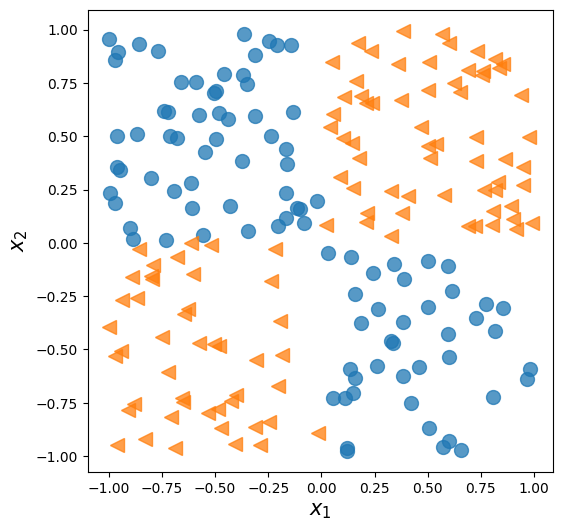

In [12]:
# generate some XOR data, split into train and test, plot the data by class
np.random.seed(1)
torch.manual_seed(1)
x = np.random.uniform(low=-1, high=1, size=(200, 2))
y = np.ones(len(x))
y[x[:, 0] * x[:, 1]<0] = 0  # label is 0 if one of the features is negative, but not both

n_train = 100
x_train = torch.tensor(x[:n_train, :], dtype=torch.float32)
y_train = torch.tensor(y[:n_train], dtype=torch.float32)
x_valid = torch.tensor(x[n_train:, :], dtype=torch.float32)
y_valid = torch.tensor(y[n_train:], dtype=torch.float32)

fig = plt.figure(figsize=(6, 6))
plt.plot(x[y==0, 0], 
         x[y==0, 1], 'o', alpha=0.75, markersize=10)
plt.plot(x[y==1, 0], 
         x[y==1, 1], '<', alpha=0.75, markersize=10)
plt.xlabel(r'$x_1$', size=15)
plt.ylabel(r'$x_2$', size=15)

#plt.savefig('figures/13_02.png', dpi=300)
plt.show()

In [14]:
# make this a TensorDataset and create a DataLoader for it
train_ds = TensorDataset(x_train, y_train)
batch_size = 2
torch.manual_seed(1)
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

In [15]:
# start with a basic model -- logistic regression -- defined via nn.Sequential
model = nn.Sequential(
    nn.Linear(2, 1),
    nn.Sigmoid()
)

model

Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
  (1): Sigmoid()
)

In [16]:
# as before, use BCELoss and SGD optimizer
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [17]:
# train this network
torch.manual_seed(1)
num_epochs = 200
def train(model, num_epochs, train_dl, x_valid, y_valid):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        for x_batch, y_batch in train_dl:
            pred = model(x_batch)[:, 0]
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()
            is_correct = ((pred>=0.5).float() == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.mean()

        loss_hist_train[epoch] /= n_train/batch_size
        accuracy_hist_train[epoch] /= n_train/batch_size

        pred = model(x_valid)[:, 0]
        loss = loss_fn(pred, y_valid)
        loss_hist_valid[epoch] = loss.item()
        is_correct = ((pred>=0.5).float() == y_valid).float()
        accuracy_hist_valid[epoch] += is_correct.mean()
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

history = train(model, num_epochs, train_dl, x_valid, y_valid)

Text(0.5, 0, 'Epochs')

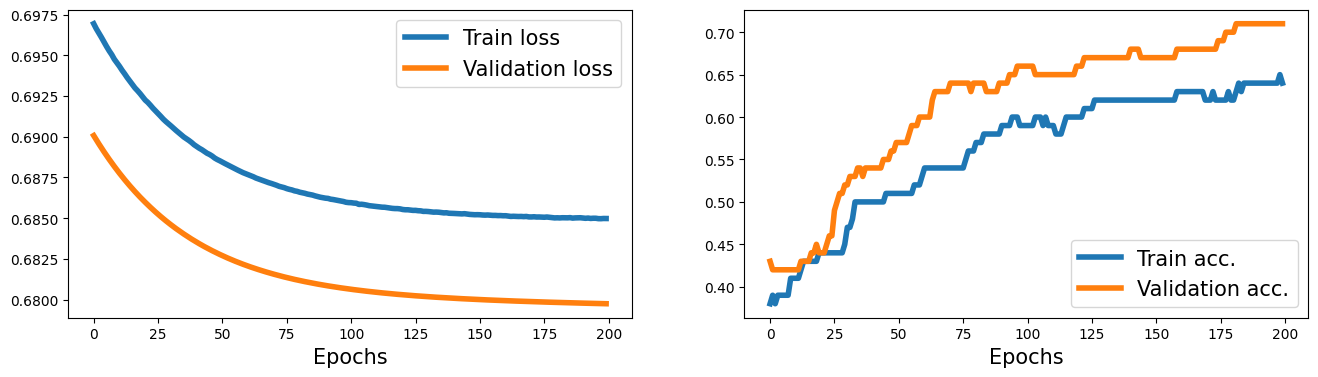

In [18]:
# plot the training and validation loss and accuracy
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 2, 1)
plt.plot(history[0], lw=4)
plt.plot(history[1], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 2, 2)
plt.plot(history[2], lw=4)
plt.plot(history[3], lw=4)
plt.legend(['Train acc.', 'Validation acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

#plt.savefig('figures/13_03.png', dpi=300)

Note that we weren't able to achieve very strong accuracy, since a simple linear model like logistic regression can't ever solve the XOR problem. Now let's try it again with a model with several layers and a nonlinear activation function (ReLU), which should give us much better accuracy.

In [23]:
# define a model with several hidden layers and ReLU activations to learn a nonlinear decision boundary
model = nn.Sequential(
    nn.Linear(2, 4),
    nn.ReLU(),
    nn.Linear(4, 4),
    nn.ReLU(),
    #nn.Linear(4, 4),
    #nn.ReLU(),
    nn.Linear(4, 1),
    nn.Sigmoid()
)

# same loss and optimization functions
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.015)

model

Sequential(
  (0): Linear(in_features=2, out_features=4, bias=True)
  (1): ReLU()
  (2): Linear(in_features=4, out_features=4, bias=True)
  (3): ReLU()
  (4): Linear(in_features=4, out_features=1, bias=True)
  (5): Sigmoid()
)

In [24]:
# use the same training procedure as before
history = train(model, num_epochs, train_dl, x_valid, y_valid)

Text(0.5, 0, 'Epochs')

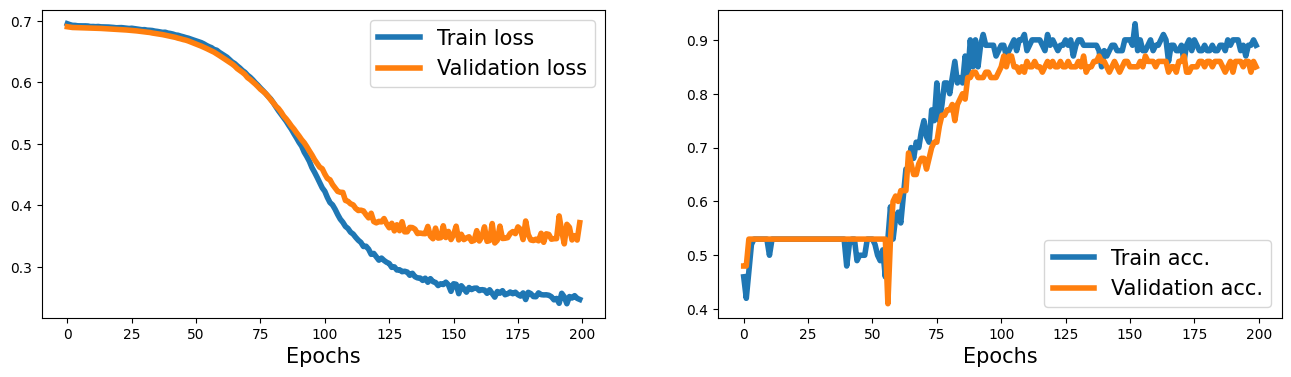

In [25]:
# again, plot the results. accuracy is much higher.
# training accuracy and loss are better than those of validation set, so there is some overfitting.
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 2, 1)
plt.plot(history[0], lw=4)
plt.plot(history[1], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 2, 2)
plt.plot(history[2], lw=4)
plt.plot(history[3], lw=4)
plt.legend(['Train acc.', 'Validation acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

#plt.savefig('figures/13_04.png', dpi=300)

### More flexible model building with nn.Module

nn.Module lets us define more customizable neural network classes, as we saw in chapter 12. Here we apply it to the same XOR problem.

In [30]:
# define a custom neural network class, extending nn.Module 
class MyModule(nn.Module):
    def __init__(self):
        super().__init__()
        l1 = nn.Linear(2, 4)
        a1 = nn.ReLU()
        l2 = nn.Linear(4, 4)
        a2 = nn.ReLU()
        l3 = nn.Linear(4, 1)
        a3 = nn.Sigmoid()
        # here we define a list of the layers, specifying their order
        # this makes it simpler to define other functions in the class, particularly forward()
        l = [l1, a1, l2, a2, l3, a3]
        self.module_list = nn.ModuleList(l)
    
    def forward(self, x):
        # with module list, the forward pass is very simple to define
        for f in self.module_list:
            x = f(x)  # set x equal to the output of the next layer in module_list
        return x

    def predict(self, x):
        # make sure input is a tensor, then call the forward pass, then convert to binary prediction
        x = torch.tensor(x, dtype=torch.float32)
        pred = self.forward(x)[:, 0]
        return (pred >= 0.5).float()  # convert to a binary class label prediction
    

model = MyModule()
model

MyModule(
  (module_list): ModuleList(
    (0): Linear(in_features=2, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=4, bias=True)
    (3): ReLU()
    (4): Linear(in_features=4, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [31]:
# again, define loss and optimizer, then train the network
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.015)
    
# torch.manual_seed(1)
history = train(model, num_epochs, train_dl, x_valid, y_valid)

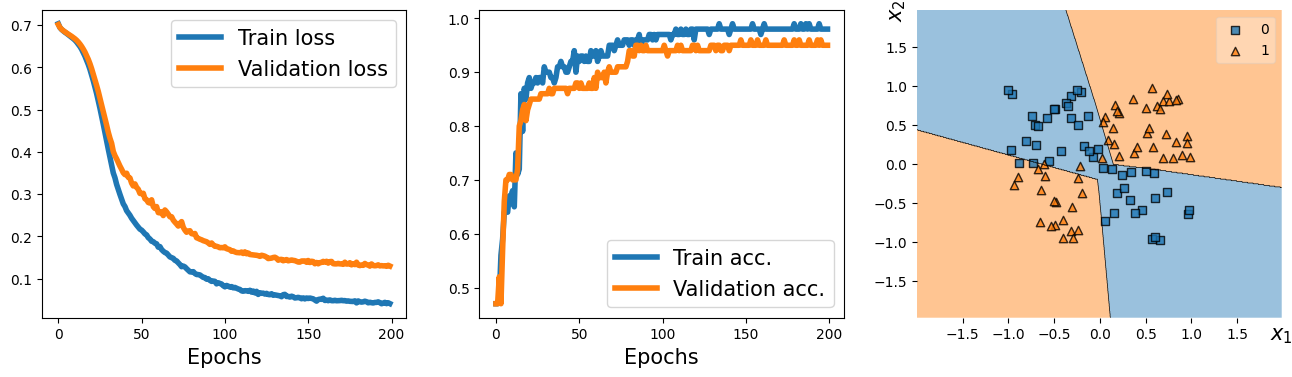

In [32]:
# we plot results,similarly to before, with similar results
# but now we also use mlxtend's plot_decision_regions to make a nice decision regions plot
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history[0], lw=4)
plt.plot(history[1], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 2)
plt.plot(history[2], lw=4)
plt.plot(history[3], lw=4)
plt.legend(['Train acc.', 'Validation acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X=x_valid.numpy(), 
                      y=y_valid.numpy().astype(np.int64),
                      clf=model)
ax.set_xlabel(r'$x_1$', size=15)
ax.xaxis.set_label_coords(1, -0.025)
ax.set_ylabel(r'$x_2$', size=15)
ax.yaxis.set_label_coords(-0.025, 1)

#plt.savefig('figures/13_05.png', dpi=300)
plt.show()

### Writing Custom Layers in PyTorch

We can also define custom layers in PyTorch, which is useful if we need to do something different than what any of the standard layers do. These layers are defined as classes that also extend the nn.Module class. We can then create a neural network module that uses instances of our layer class within its architecture. In our example below, we define a NoisyLinear layer that is similar to a standard wx + b linear layer, but instad adds some random noise (e) to the input data x, so we have w(x + e) + b. This may not be that useful in our particular case (though it may help with overfitting), but it serves as a good simple example of a custom layer.

In [37]:
# here we define our NoisyLinear class, which also extends nn.Module 
# noise_stddev is the standard deviation of the noise we will add to input x
class NoisyLinear(nn.Module):
    def __init__(self, input_size, output_size, noise_stddev=0.1):
        super().__init__()
        w = torch.Tensor(input_size, output_size)
        self.w = nn.Parameter(w)  # nn.Parameter is a Tensor that's a module parameter.
        nn.init.xavier_uniform_(self.w)
        b = torch.Tensor(output_size).fill_(0)
        self.b = nn.Parameter(b)
        self.noise_stddev = noise_stddev
    
    def forward(self, x, training=False):
        # we take in a separate argument that tells us whether we are training or merely predicting
        # we want to add noise if we are training, to help us limit overfitting
        # but during prediction, there is no need to add noise -- this would just hurt performance
        if training:
            noise = torch.normal(0.0, self.noise_stddev, x.shape)
            x_new = torch.add(x, noise)
        else:
            x_new = x
        # forward here is just the operation w * x_new + b,
        #    where x_new has added noise if training is True
        return torch.add(torch.mm(x_new, self.w), self.b) 

In [38]:
# let's test that the behavior is different depending on whether training is True
# input is zeros and so is default bias, so should be zeros if not noisy, or nonzero otherwise
torch.manual_seed(1)

noisy_layer = NoisyLinear(4, 2)
 
x = torch.zeros((1, 4))
print(noisy_layer(x, training=True))

print(noisy_layer(x, training=True))
 
print(noisy_layer(x, training=False))
 

tensor([[ 0.1154, -0.0598]], grad_fn=<AddBackward0>)
tensor([[ 0.0432, -0.0375]], grad_fn=<AddBackward0>)
tensor([[0., 0.]], grad_fn=<AddBackward0>)


In [ ]:
# now let's define a nn module that uses this noisy layer
# it's the same as before except the first Linear is replaced by our NoisyLinear module
class MyNoisyModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = NoisyLinear(2, 4, 0.07)
        self.a1 = nn.ReLU()
        self.l2 = nn.Linear(4, 4)
        self.a2 = nn.ReLU()
        self.l3 = nn.Linear(4, 1)
        self.a3 = nn.Sigmoid()
        
    def forward(self, x, training=False):  # training parameter for NoisyLinear
        x = self.l1(x, training)
        x = self.a1(x)
        x = self.l2(x)
        x = self.a2(x)
        x = self.l3(x)
        x = self.a3(x)
        return x
    
    def predict(self, x):
        x = torch.tensor(x, dtype=torch.float32)
        pred = self.forward(x)[:, 0]
        return (pred>=0.5).float()

torch.manual_seed(1)
model = MyNoisyModule()
model

MyNoisyModule(
  (l1): NoisyLinear()
  (a1): ReLU()
  (l2): Linear(in_features=4, out_features=4, bias=True)
  (a2): ReLU()
  (l3): Linear(in_features=4, out_features=1, bias=True)
  (a3): Sigmoid()
)

In [ ]:
# train the model, similarly to before, except we need to tell it to set training=True for NoisyLinear
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.015)
    
torch.manual_seed(1)

loss_hist_train = [0] * num_epochs
accuracy_hist_train = [0] * num_epochs
loss_hist_valid = [0] * num_epochs
accuracy_hist_valid = [0] * num_epochs
for epoch in range(num_epochs):
    for x_batch, y_batch in train_dl:
        pred = model(x_batch, True)[:, 0]  # training set to True here
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_hist_train[epoch] += loss.item()
        is_correct = ((pred>=0.5).float() == y_batch).float()
        accuracy_hist_train[epoch] += is_correct.mean()

    loss_hist_train[epoch] /= n_train/batch_size
    accuracy_hist_train[epoch] /= n_train/batch_size

    pred = model(x_valid)[:, 0]  # training is False here (by default), since now we're just predicting
    loss = loss_fn(pred, y_valid)
    loss_hist_valid[epoch] = loss.item()
    is_correct = ((pred>=0.5).float() == y_valid).float()
    accuracy_hist_valid[epoch] += is_correct.mean()

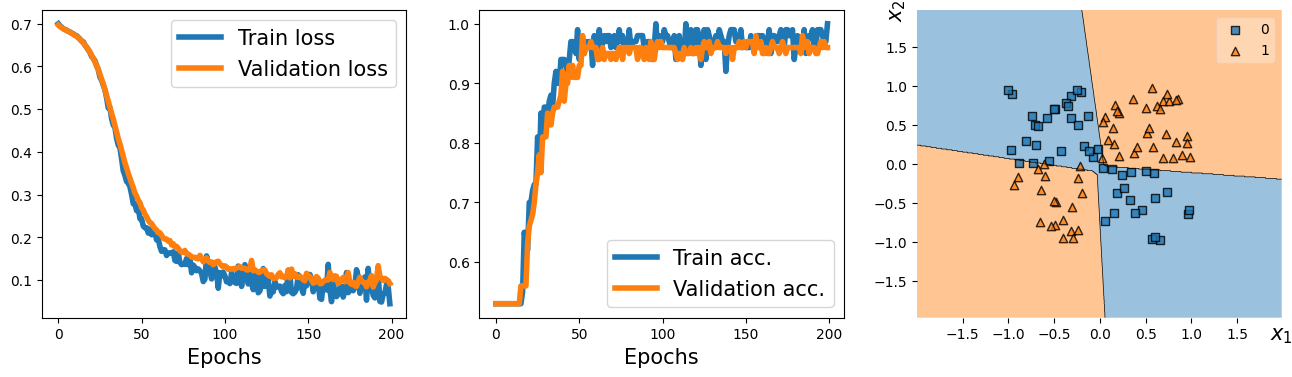

In [41]:
# plot the results, as before. notice how the training-validation gap is smaller!
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(loss_hist_train, lw=4)
plt.plot(loss_hist_valid, lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 2)
plt.plot(accuracy_hist_train, lw=4)
plt.plot(accuracy_hist_valid, lw=4)
plt.legend(['Train acc.', 'Validation acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X=x_valid.numpy(), 
                      y=y_valid.numpy().astype(np.int64),
                      clf=model)
ax.set_xlabel(r'$x_1$', size=15)
ax.xaxis.set_label_coords(1, -0.025)
ax.set_ylabel(r'$x_2$', size=15)
ax.yaxis.set_label_coords(-0.025, 1)

#plt.savefig('figures/13_06.png', dpi=300)
plt.show()